# HUB4045F 2024: Medical Imaging and Image Processing

**Name**: Bonga Njamela 
<br>
**Student Number**: NJMLUN002
<br>
**Email Address**: njmlun002@myuct.ac.za
<br>
**Date**: 8 April 2024

# Assignment 2: Segmentation and Basic Shape Analysis

## Plagiarism Declaration

1. I know that plagiarism is wrong. Plagiarism is to use another’s work and pretend it is one’s own.
2. Each significant contribution to, and quotation in this assignment that I have taken from the work(s) of other people has been attributed, and has been cited and referenced.
3. I have used the IEEE system for citation and referencing.
4. This assignment is my own work and I have not copied any other text.
5. I have not allowed, and will not allow, anyone to copy my work with the intention of passing it off as his or her own work. 

## Imports and Notebook Configuration

### Installing packages:

The following notebook requires installation of $\texttt{matplotlib}$; $\texttt{numpy}$; $\texttt{scipy}$; $\texttt{openCV}$; $\texttt{pydicom}$; $\texttt{skimage}$; and $\texttt{glob}$. 

1. Open a Terminal or Command Prompt: Use a terminal or command prompt to execute the installation command.
<br><br>
2. Run the Installation Command: Use the following command to install Matplotlib and Numpy via pip:
<br><br>
\\$ $\texttt{pip install matplotlib}$<br>
\\$ $\texttt{pip install numpy}$<br>
\\$ $\texttt{pip install scipy}$<br>
\\$ $\texttt{pip install opencv-python}$<br>
\\$ $\texttt{pip install -U pydicom}$<br>
\\$ $\texttt{pip install scikit-image}$<br>
\\$ $\texttt{pip install glob2}$<br>
\\$ $\texttt{pip install trimesh}$
<br><br>
3. If you're using Python 3 and have multiple versions of Python installed, you might need to use pip3 instead of pip:
<br><br>
\\$ $\texttt{pip3 install matplotlib}$<br>
\\$ $\texttt{pip3 install numpy}$<br>
\\$ $\texttt{pip3 install scipy}$<br>
\\$ $\texttt{pip3 install opencv-python}$<br>
\\$ $\texttt{pip3 install -U pydicom}$<br>
\\$ $\texttt{pip3 install scikit-image}$<br>
\\$ $\texttt{pip3 install glob2}$<br>
\\$ $\texttt{pip install trimesh}$

<br><br>
4. Verify Installation: After the installation is complete, verify that Matplotlib is installed correctly by opening a Python interpreter and importing the library:
<br><br>
import matplotlib<br>
import numpy<br>
import cv2 #openCV package<br>
import pydicom as DCM <br>
import scipy<br>
import skimage<br>
import glob<br>
import trimesh

print(matplotlib.\_\_version\_\_)<br>
print(numpy.\_\_version\_\_)<br>
print(cv2.\_\_version\_\_)<br>
print(DCM.\_\_version\_\_)<br>
print(scipy.\_\_version\_\_)<br>
print(skimage.\_\_version\_\_)<br>
print(trimesh.\_\_version\_\_)
<br><br>
5. This should print the version number of Matplotlib, Numpy, OpenCV, Pydicom, and Scipy, installed on your system. This can also be done by uncommenting the calls to $\texttt{print}$ in the cell below.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
import pydicom as DCM
import skimage
import glob
import trimesh

from skimage.feature import canny
from skimage import data
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill
from skimage.util import img_as_ubyte
from skimage import img_as_float
from skimage import exposure
from skimage.filters import threshold_multiotsu
from scipy.spatial import procrustes


# Uncomment lines below to verify installation
#print(matplotlib.__version__)
#print(np.__version__)
#print(cv2.__version__)
#print(DCM.__version__)
#print(scipy.__version__)
#print(skimage.__version__)
#print(trimesh.__version__)

## Question 1: Segmentation

#### Display image 

The code below loads and displays the DICOM image named 'CTimage.dcm'. DICOM files contain patient information and data related to the context and acquisition of the imaging study [1]. The $\texttt{dcmread}$ function from the $\texttt{pydicom}$ library is used to load the DICOM image data into the variable $\texttt{ctdicom}$ first, then $\texttt{matplotlib}$ is used to display the image's pixel values stored in the $\texttt{ctimage}$ $\texttt{pixel_array}$. 

We use the $\texttt{convertScaleAbs}$ function to calculate absolute value for each element of the $\texttt{ctimage}$ pixel array, and converts the result to an 8-bit type integer. The effect of this conversion is to enhance the view of the image by scaling the intensity of each pixel relative to the background.

In [2]:
# load dicom image
ctdicom = DCM.dcmread("CTimage.dcm")

# generate array of pixels
ctimage = ctdicom.pixel_array

# convert image to uint8 mask
ctimage_uint8 =  cv2.convertScaleAbs(ctimage)


# display original image using imshow
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ctimage, cmap='gray')
plt.axis('on')
plt.title('Original CT Image')

plt.subplot(1, 2, 2)
plt.imshow(ctimage_uint8, cmap='gray')
plt.axis('on')
plt.title('8-bit Original CT Image')

plt.show()

To isolate the left leg, we first trace the edges of the image using ridge detection. 

#### Reduce noise using Gaussian Filter with a 5x5 Kernel

First, we smooth the image by implementing a Gaussian filter - using the $\texttt{cv2.GaussianBlur}$ function - which convolves the binary CT image with a 5x5 kernel. The shape of the kernel resembles the 'bell-shape' of the Gaussian normal distribution curve [2]. After applying the filter, the image is expected to appear blurred.

In [3]:
# Gaussian filter with a 5x5 kernel
ctimage_gaussian = cv2.GaussianBlur(ctimage_uint8, (5, 5), 0)

#### Approximating derivatives for edge detection

We use a Sobel kernel as the base kernel to obtain a good indication of the edgeness. Sharp and steep edges are expected to have large associated derivatives values and smooth edges have a small derivative [3].

For two-dimensional images, the slope of the grey value function in a pixal depends on the view direction [3]. The edgeness $g$ of the CT image is an approximation of the gradient norm. The Sobel kernel determines the weighted average derivative across three lines such that the weight of the center line derivative is double the weight of the other two lines. Given the Sobel kernels $k_1$ and $k_2$,

$k_1 = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}$

$k_2 = \begin{bmatrix}
-1 & -2 & -1\\
-0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}$

the edgeness of the image $g$ is

$g = \sqrt{(k_1 * f)^2+(k_2 * f)^2}$.

In [4]:
# Derivative of the CT image in the x-direction
f_x = cv2.Sobel(ctimage_gaussian, cv2.CV_64F, 1, 0, ksize=3)

# Derivate of the CT image in the y-direction
f_y = cv2.Sobel(ctimage_gaussian, cv2.CV_64F, 0, 1, ksize=3)

# Gradient norm approximating maximal derivative
grad_norm = np.sqrt(f_x**2 + f_y**2)

# Convert gradient normal to 
grad_norm_uint8 = cv2.convertScaleAbs(grad_norm)

#### Enhance regions of maximal gradient

We apply Ostu thresholding to enhance the regions that were determined to have maximum slope above. This effectively binarizes the image based on pixel intensities. The Otsu thresholding algorithm segments the objects in the image by minimizing the variance of each of the classes presented in the image histogram. This helps in further isolating edges that are distorted by smoothing due to the similarity of their grey level.

<function matplotlib.pyplot.show(close=None, block=None)>

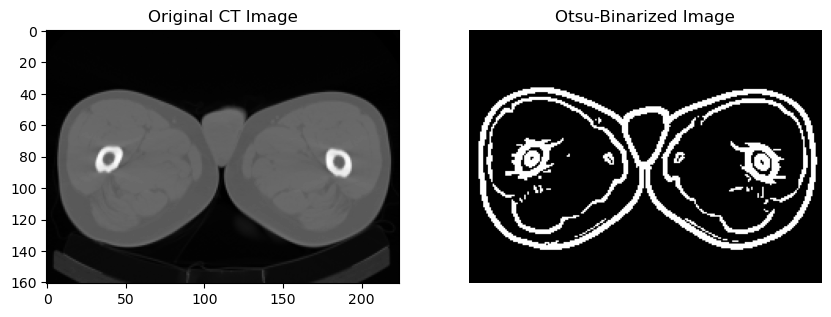

In [5]:
# Apply thresholding to get binary image
_, binarized_otsu = cv2.threshold(grad_norm_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ctimage, cmap='gray')
plt.axis('on')
plt.title('Original CT Image')

# Show binary image using Otsu thresholding.
plt.subplot(1, 2, 2)
plt.imshow(binarized_otsu, cmap='gray')
plt.title('Otsu-Binarized Image')
plt.axis('off')
plt.show

#### Use morphological operation to enhance ridge structures

Here, we use the function $\texttt{cv2.morphologyEx}$ to perform morphological closing and opening morphological operations on the Otsu-binarized edges shown above. Closing is done by first performing dilation, followed by erosion. This could be useful for closing small holes in the edges. Morphological opening is achieved by performing erosion first, followed by dilation. We compare the two find the most suitable operation.

In [6]:
# Create a 3x3 kernel to perform morphological operations
kernel = np.ones((3, 3), np.uint8)

# Perform morphological opening (erode -> dilated)
morph_opened = cv2.morphologyEx(binarized_otsu, cv2.MORPH_OPEN, kernel)

# Perform morphological closing (dilate -> erode)
morph_closed = cv2.morphologyEx(binarized_otsu, cv2.MORPH_CLOSE, kernel)

# Show 3 images 
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(ctimage, cmap='gray')
plt.title('Original CT Image')
plt.axis('off')

# Show morphological closing
plt.subplot(1, 3, 2)
plt.imshow(morph_closed, cmap='gray')
plt.title('Post-morphological closing')
plt.axis('on')

# Show morphological opening
plt.subplot(1, 3, 3)
plt.imshow(morph_opened, cmap='gray')
plt.title('Post-morphological opening')
plt.axis('on')

plt.show()

The edges obtained after perfoming morphological opening are more suitable for selecting the outer-edge of the left leg.

### Crop the opened edges

We use the opened edges from above to isolate the left leg by first cropping the edges in half so that the remaining contour is the left leg contour. From the above, we note that the x-axis range for the left leg contour is [0, 112] and the y-axis range is [37,160].

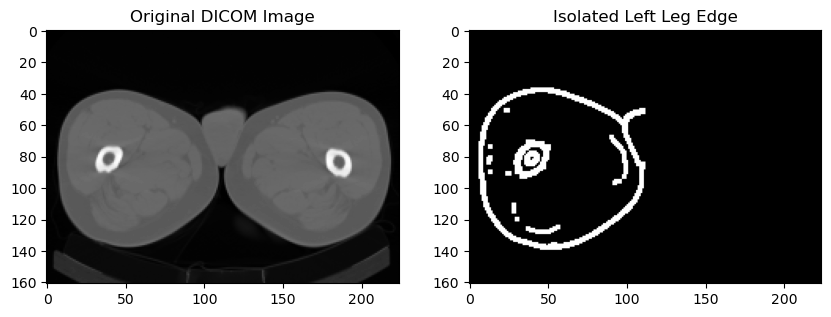

In [7]:
# Define coordinates for the left leg region
x_start, x_end = 0, 112  # X-axis range for the left leg
y_start, y_end = 37, 160  # Y-axis range for the left leg

# Create a kernel from the binarized opened edges
opened_kernel = np.zeros_like(morph_opened)

# Crop opened kernel in the x-y dimension.
opened_kernel[y_start:y_end, x_start:x_end] = 250

# Apply the kernel to make everything except the left leg black
isolated_edges = morph_opened * opened_kernel

# Showing original image and the isolated left leg ridges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ctimage, cmap='gray')
plt.title('Original DICOM Image')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(isolated_edges, cmap='gray')
plt.title('Isolated Left Leg Edge')
plt.axis('on')

plt.show()

#### Canny edge detection on isolated edges

To obtain extract the inner contour, we use Canny edge detection to trace the outer edge of the left leg. The Canny edge detection algorithm has 4 steps, including some of the steps perform above such as Gaussian smoothing and derivative approximation using Sobel matrices. The Canny method differs from the one applied above in that it applies non-maximum suppression as well as hysteresis thresholding.

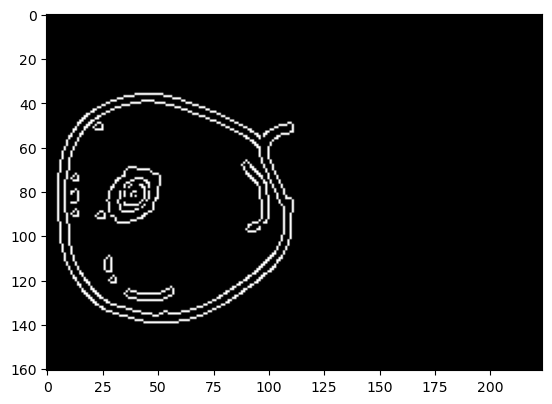

In [8]:
edges = cv2.Canny(isolated_edges, 20, 20)
edges.shape
plt.imshow(edges, cmap='gray')

We see that the thick opened-edges form two outer and inner contours. The next step uses the inner contour, which is the largest completely closed and connected region, to isolate the left leg.

#### Isolate left leg use edge-contours

We can find simple closed and connected regions using the $\texttt{cv2.findContours}$ which retrieves contours from the binary image using the Suzuki contour algorithm.

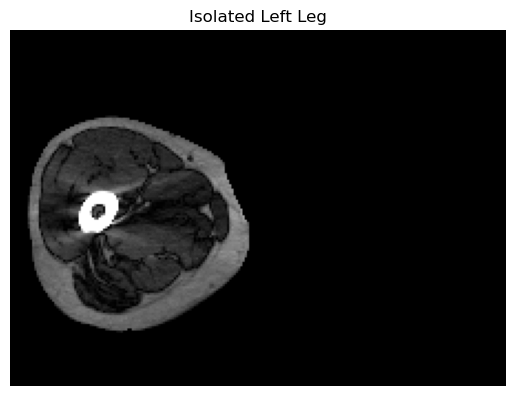

In [9]:
# Find the regions
regions, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours to find the largest one (assuming it's the boundary of the left leg region)
max_region = max(regions, key=cv2.contourArea)

# Create a kernel image
contour_kernel = np.zeros_like(edges)

# mask = cv2.bitwise_and(isolated_leg, isolated_leg, mask=mask)
cv2.drawContours(contour_kernel, [max_region], -1, (255), thickness=cv2.FILLED)

# Apply mask to isolate the left leg
final_leg_isolated = cv2.bitwise_and(ctimage_uint8, ctimage_uint8, mask=contour_kernel)

# Show the result
plt.imshow(final_leg_isolated, cmap='gray')
plt.title('Isolated Left Leg')
plt.axis('off')
plt.show()

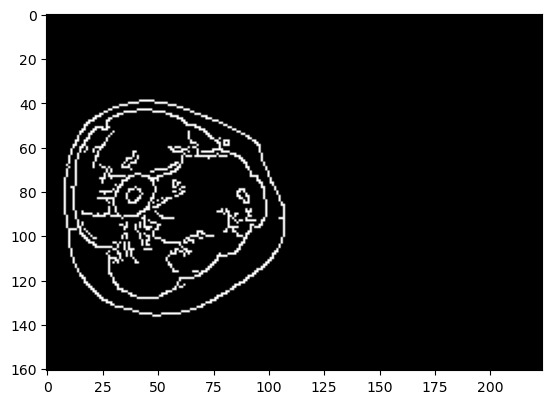

In [10]:
# blurred = cv2.medianBlur(final_leg_isolated, 5)
edges_final = cv2.Canny(final_leg_isolated, 90, 255)
edges_final.shape 
plt.imshow(edges_final, cmap='gray')

#### Perform k-means clustering to isolate muscle, leg and bone

We fit the k-means algorithm on the reshaped image of the isolated left leg to obtain clusters using the $\texttt{cv2.kmeans}$ function. Here, we use k = 4, to separate the muscle (quadriceps femoris), leg (fascia lata) and the bone (femur). The additional cluster is used to compensate for the areas of the muscle which have a similar attenuation coefficient to that of the leg tissue surrounding the muscle. 

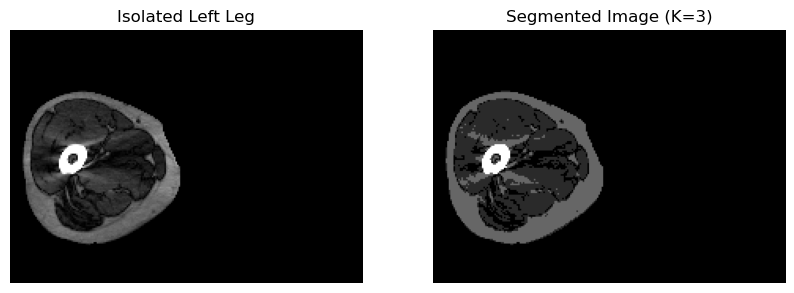

In [11]:
# Reshape image
pic_n = final_leg_isolated.reshape((-1, 1))

# Convert to float32
pic_n = np.float32(pic_n)

# Define criteria and apply K-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 15.0)
k = 4 # Number of clusters
_, labels, centers = cv2.kmeans(pic_n, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to uint8
centers = np.uint8(centers)

# Flatten the labels array
labels = labels.flatten()

# Reshape the segmented image
clustered_im = centers[labels.flatten()]

# Reshape the segmented image back to the original shape
clustered_image = clustered_im.reshape(final_leg_isolated.shape)

# Show the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(final_leg_isolated, cmap='gray')
plt.title('Isolated Left Leg')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clustered_image, cmap='gray')
plt.title('Segmented Image (K=3)')
plt.axis('off')

plt.show()


#### Isolate each cluster and save it to a png file

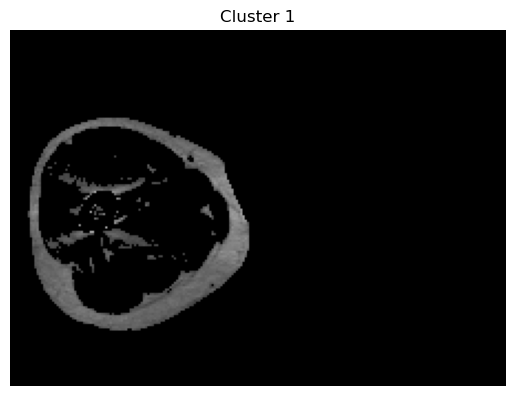

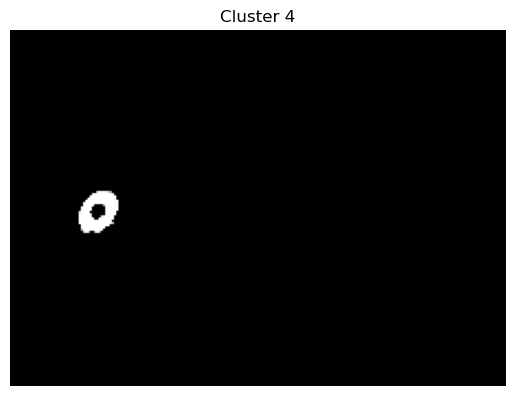

In [12]:
# Reshape the labels to the isolated leg image shape
labels = labels.reshape(final_leg_isolated.shape[:2])

# Create and save an image for each cluster
for i in range(k):
    # Create a kernel for the current cluster
    cluster_kernel = labels == i
    
    # Apply the kernel to the original image to extract the cluster
    cluster_image = np.zeros_like(final_leg_isolated)
    cluster_image[cluster_kernel] = final_leg_isolated[cluster_kernel]

    # Save the cluster image
    cv2.imwrite(f'cluster_{i+1}.png', cluster_image)

    # Plot the cluster image
    plt.figure()
    plt.imshow(cv2.cvtColor(cluster_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Cluster {i+1}')
    plt.axis('off')

plt.show()

#### Calculate Areas and Collate Clusters

We look at each image to see the image and its corresponding structure. We then calculate the area of each image and associate that area with a cluster so that we can caliberate the program to associate each cluster image with the correct tissue. 

\* This was done to go around the undeterministic behaviour of the clustering by the k-means algorithm. Each time the code is run, the clusters are saved to a different file. So for example, bone could be save as cluster_1.png after running for the first time and after running the code again, bone could be saved as cluster_3.png.

In [13]:
# Open cluster images
cluster_image_a = cv2.imread('cluster_1.png')
cluster_image_b = cv2.imread('cluster_2.png')
cluster_image_c = cv2.imread('cluster_3.png')
cluster_image_d = cv2.imread('cluster_4.png')

# Calculate area occupied by nonzero (nonbackground)
# pixels => area of muscle, leg and bone
area_a = np.sum(cluster_image_a > 0)
area_b = np.sum(cluster_image_b > 0)
area_c = np.sum(cluster_image_c > 0)
area_d = np.sum(cluster_image_d > 0)

# Use to determine corresponding areas
# print("Area occupied by cluster 1:", area_a)
# print("Area occupied by cluster 2:", area_b) 
# print("Area occupied by cluster 3:", area_c) 
# print("Area occupied by cluster 4:", area_d) 

# Area of bone
if (300 < area_a < 900):
    bone = cluster_image_a
elif (300 < area_b < 900):
    bone = cluster_image_b
elif (300 < area_c < 900):
    bone = cluster_image_c
else:
    bone = cluster_image_d
print("Area occupied by bone:", np.sum(bone > 0))

# Area of quad muscles surrounding femur
if (10000 < area_a < 11000):
    femoris_1 = cluster_image_a
elif (10000 < area_b < 11000):
    femoris_1 = cluster_image_b
elif (10000 < area_c < 11000):
    femoris_1 = cluster_image_c
else:
    femoris_1 = cluster_image_d

if (2000 < area_a < 4000):
    femoris_2 = cluster_image_a
elif (2000 < area_b < 4000):
    femoris_2 = cluster_image_b
elif (2000 < area_c < 4000):
    femoris_2 = cluster_image_c
else:
    femoris_2 = cluster_image_d

femoris = cv2.add(femoris_1, femoris_2)
print("Area occupied by muscle:", np.sum(femoris > 0))

#Area of leg
if (6000 < area_a < 9000):
    fascia = cluster_image_a
elif (6000 < area_b < 9000):
    fascia = cluster_image_b
elif (6000 < area_c < 9000):
    fascia = cluster_image_c
else:
    fascia = cluster_image_d

print("Area occupied by fascia lata:", np.sum(fascia > 0))

Area occupied by bone: 675
Area occupied by muscle: 13581
Area occupied by fascia lata: 8262


#### Isolate leg cluster and make it white

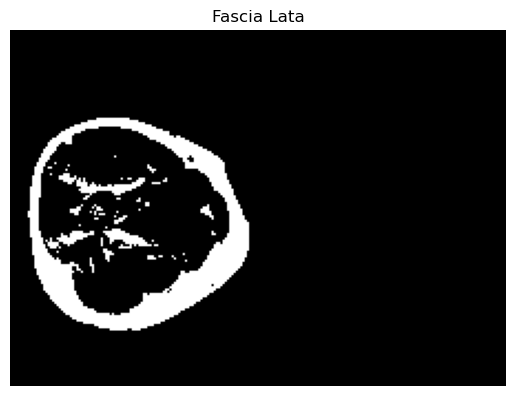

In [14]:
# Define the background color 
background_color = np.array([0, 0, 0], dtype=np.uint8)

# Create a mask fascia lata
fascia_mask = np.all(fascia == background_color, axis=-1)

# Create a mask for non-background pixels
non_background_mask = ~fascia_mask

# Define white colour
white_color = np.array([255, 255, 255], dtype=np.uint8)

# Set non-background pixels to white
fascia[non_background_mask] = white_color

plt.imshow(cv2.cvtColor(fascia, cv2.COLOR_BGR2RGB))
plt.title('Fascia Lata')
plt.axis('off')  # Turn off axis
plt.show()

plt.show()

#### Isolate muscle and make it red

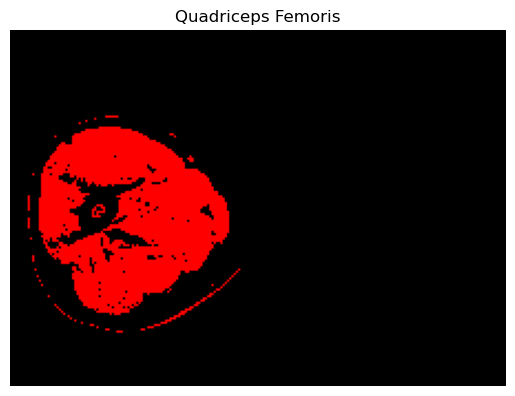

In [15]:
# Create a mask for muscle
muscle_mask = np.all(femoris == background_color, axis=-1)

# Create a mask for non-background pixels
non_background_mask = ~muscle_mask

# Define red colour
red_color = np.array([0, 0, 255], dtype=np.uint8)

# Set non-background pixels to red
femoris[non_background_mask] = red_color

plt.imshow(cv2.cvtColor(femoris, cv2.COLOR_BGR2RGB))
plt.title('Quadriceps Femoris')
plt.axis('off')  # Turn off axis
plt.show()

plt.show()

#### Isolate bone and make it yellow

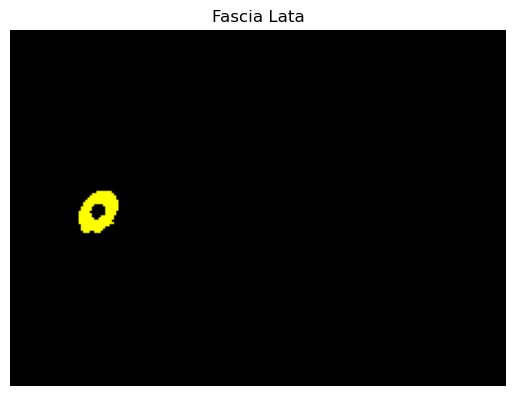

In [16]:
# Create a mask for the background pixels
bone_mask = np.all(bone == background_color, axis=-1)

# Create a mask for non-background pixels
non_background_mask = ~bone_mask

# Define yellow colour
yellow_color = np.array([0, 255, 255], dtype=np.uint8)

# Set non-background pixels to yellow
bone[non_background_mask] = yellow_color

plt.imshow(cv2.cvtColor(bone, cv2.COLOR_BGR2RGB))
plt.title('Fascia Lata')
plt.axis('off')  # Turn off axis
plt.show()

plt.show()

#### Recombine isolated tissue into one image

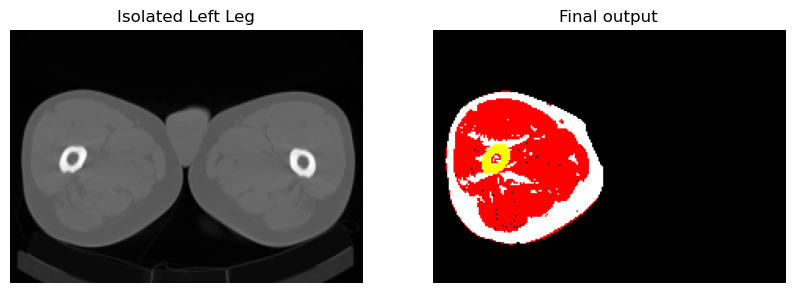

In [17]:
# Add the images together
result = cv2.add(fascia, femoris)
result = cv2.add(result, bone)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ctimage, cmap='gray')
plt.title('Isolated Left Leg')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Final output')
plt.axis('off')  # Turn off axis

plt.show()

#### Smooth image using Gaussian filter

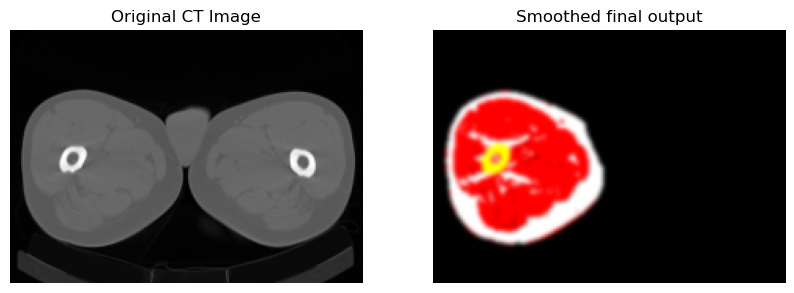

In [18]:
smoothed_result = cv2.GaussianBlur(result, (7, 7), 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ctimage, cmap='gray')
plt.title('Original CT Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(smoothed_result, cv2.COLOR_BGR2RGB))
plt.title('Smoothed final output')
plt.axis('off')  # Turn off axis
plt.show()

plt.show()

#### Sharpen image using enhancement kernel

In [19]:
# Enhancing kernel
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])

# Apply the enhancing kernel
sharpened_image = cv2.filter2D(smoothed_result, -1, sharpening_kernel)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ctimage, cmap='gray')
plt.title('Original CT Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.title('Sharpened final output')
plt.axis('off')  # Turn off axis
plt.show()

### Question 2: Import surfaces

#### Load meshes

In [20]:
# Load meshes
femur1 = trimesh.load_mesh('femur1.stl')
femur2 = trimesh.load_mesh('femur2.stl')

#### Display femur1.stl

In [21]:
femur1.show()

#### Display femur2.stl

In [22]:
femur2.show()

#### Requirements for correspondence

Comparing two shapes requires correspondence, i.e. determining the correlation between points on one surface and points on the other surface. To perform this correspondence, we would need to first select features in the reference image and search for them in the sensed image. Alternatively, we could select features in both images independently and then determine the correspondence between them. The coordinates of corresponding points are used to determine transformation parameters. If we use regions, the centroids and Hu moments represent corresponding points. If we use lines, intersections between line pairs represents their correspondence.


#### Number of vertices, faces and isotopology

To determine whether the shapes are isotopological, we determine the number of vertices and faces in each mesh. If the shapes have the same number of vertices and faces, then they are isotopological and the $\texttt{iso_topological}$ variable is set to true.

In [23]:
# Store number of faces femur1 and femur2
faces_femur1 = len(femur1.faces)
faces_femur2 = len(femur2.faces)

# Store number of vertices for femur1 and femur2
verts_femur1 = len(femur1.vertices)
verts_femur2 = len(femur2.vertices)


# Show femur1 vertices and faces
print("======= Properties of Femur Mesh 1 =======")
print("Vertices in femur1:", verts_femur1)
print("Faces in femur1:", faces_femur1)
print()

# Show femur2 vertices and faces
print("======= Properties of Femur Mesh 2 =======")
print("Vertices in femur2:", verts_femur2)
print("Faces in femur2:", faces_femur2)
print()
# Check if they are iso-topological
isEqualVertices = verts_femur1 == verts_femur2
isEqualFaces = faces_femur1 == faces_femur2

# Determine if femur1 and femur2 are isotropic
isotop = isEqualVertices and isEqualFaces
print("======= Femur1 || Femur2 =======")
print("Isotopological:", isotop)

======= Properties of Femur Mesh 1 =======
Vertices in femur1: 1000
Faces in femur1: 1996

======= Properties of Femur Mesh 2 =======
Vertices in femur2: 1000
Faces in femur2: 1996

======= Femur1 || Femur2 =======
Isotopological: True


### Question 3: Shape matching


#### Direct Method

We calculate the average spatial position of each point on the surface by averaging the number of vertices in both meshes. The resulting surface is shown with an average spatial position between femur1 and femur2.

In [24]:
# Find the 
mean_verts = (femur1.vertices + femur2.vertices) / 2

# Generate a new mesh with the average vertices
mean_mesh = trimesh.Trimesh(vertices=mean_verts, faces=femur1.faces)

# Show the resulting average surface
mean_mesh.show()

#### Rigid alignment method

We filter out location, scale and rotational effects on the points on each surface to obtain a true shape representation by employing procrustes analysis. Procrustes analysis involves four steps, namely: 

1. Computing the centroid of each femur
2. Re-scaling each femur to have equal size
3. Aligning the two femurs at their centroids with respect to position
4. Aligning the femurs with respect to orientation by rotating them.

The $\texttt{procrustes}$ function does this similarity test for two data sets, in this case two meshes, by standardizing both surface points such that both sets are centered around the origin.

In [25]:
#help(procrustes)

# Procrustes analysis
_, _, target_femur2 = procrustes(femur1.vertices, femur2.vertices)

# Determine the expected spatial position
aligned_vertices = (femur1.vertices + target_femur2) / 2

# Generate the new aligned mesh
aligned_mesh = trimesh.Trimesh(vertices=aligned_vertices, faces=femur1.faces)

# Show the aligned mesh
aligned_mesh.show()

#### Displaying the resulting surfaces from both methods

The $\texttt{trimesh.Scene}$ function generates a simple scene graph which adds meshes by name so that they can be moved by the updating transform in the transform tree.

In [26]:
#help(trimesh.Scene)
scene = trimesh.Scene([mean_mesh, aligned_mesh])
scene.show()

The scene shows that the while both methods are effective, their average output spatial position is not the equivalent.

#### Investigating other ways to improve the registration process

We can improve the registration process by preprocessing the surfaces to enhance the quality by filtering noise and removing artifacts before registration. Using an enhancement kernel can improve the ability to locate and describe features. Enhancement would also help to improve feature correspondence by increasing the intensity of feature pixels.

We can also use Hu moments to find the distance $D$ between the two shapes. If the distance is small, we can assume that the shapes are very similar and if the distance is larger, the shapes are less similar. 

## References

1. T. Mutsvangwa and C. Namayega, "Pre-segmentation and image manipulation", Medical Imaging and Image Processing Lecture Series, University of Cape Town, Cape Town, ZA, 2024. [Online]. Available: https://amathuba.uct.ac.za/d2l/le/lessons/50939/topics/2274965. [Accessed: 22 March 2024]
<br><br>
2. R. Fisher et al., “Spatial Filters - Gaussian Smoothing”, University of Edinburgh, United Kingdom, 2019. [Online]. Available: https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm
[Accessed: 7 April 2024]
<br><br>
3. S. Haldo and J. Cardelino. "A review of classic edge detectors." Image Processing On Line 5 (2015): 90-123.
<br><br>
4. R. Haralick and L. Shapiro, "Computer and Robot Vision", Addison-Wesley Publishing Company, 1992, Vol. 1, Chap. 7.